## Overview
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail</a> is a transnational dataset which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Source
UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/online+retail

## Business Goal
To segment the Customers based on RFM so that the company can target its customers efficiently.

## Methodology

1. [Reading and Understanding the Data](#1) <br>
    a. Creating a Data Dictionary
2. [Data Cleaning](#2)
3. [Data Preparation](#3) <br>
    a. Scaling Variables
4. [Model Building](#4) <br>
    a. K-means Clustering <br>
    b. Finding the Optimal K
5. [Final Analysis](#5)

<a id="1"></a> <br>
### 1 : Reading and Understanding Data

In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly as py 
import plotly.graph_objs as go

from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# Reading the data on which analysis needs to be done
retail = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')

#### Data Dictionary 

First Header  | Definition    |  Description  | Data Type
------------- | ------------- | ------------- | -------------
InvoiceNo  | Invoice number | A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. | Nominal
StockCode | Product (item) code | A 5-digit integral number uniquely assigned to each distinct product. | Nominal
Description | Product (item) name | Name of Product | Nominal
Quantity | Quantity | The quantities of each product (item) per transaction | Numeric
InvoiceDate | Invoice Date and time | The day and time when each transaction was generated. | Numeric
UnitPrice | Unit price | Product price per unit in sterling. | Numeric
CustomerID | Customer number | A 5-digit integral number uniquely assigned to each customer. | Nominal
Country | Country name | The name of the country where each customer resides. | Nominal

In [3]:
#show all columns on output
pd.set_option('display.max_columns', None)

In [4]:
retail.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01-12-2010 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01-12-2010 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01-12-2010 08:34,1.69,13047.0,United Kingdom


`Explanation:` First, the dataset is loaded into Jupyter notebook, and the initial step was to show the first ten rows of the dataset.

In [438]:
# shape of df
retail.shape

(541909, 8)

In [439]:
# df description
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [440]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


<a id="2"></a> <br>
### 2 : Data Cleaning

In [441]:
# Inspecting InvoiceDate

retail['InvoiceDate'].head(10)

0    01-12-2010 08:26
1    01-12-2010 08:26
2    01-12-2010 08:26
3    01-12-2010 08:26
4    01-12-2010 08:26
5    01-12-2010 08:26
6    01-12-2010 08:26
7    01-12-2010 08:28
8    01-12-2010 08:28
9    01-12-2010 08:34
Name: InvoiceDate, dtype: object

In [442]:
# Converting InvoiceDate to datetime

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], dayfirst=True)

In [443]:
# Inspecting InvoiceDate

retail['InvoiceDate'].head(10)

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
5   2010-12-01 08:26:00
6   2010-12-01 08:26:00
7   2010-12-01 08:28:00
8   2010-12-01 08:28:00
9   2010-12-01 08:34:00
Name: InvoiceDate, dtype: datetime64[ns]

In [444]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [445]:
# Calculating the Missing Values % contribution in DF
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

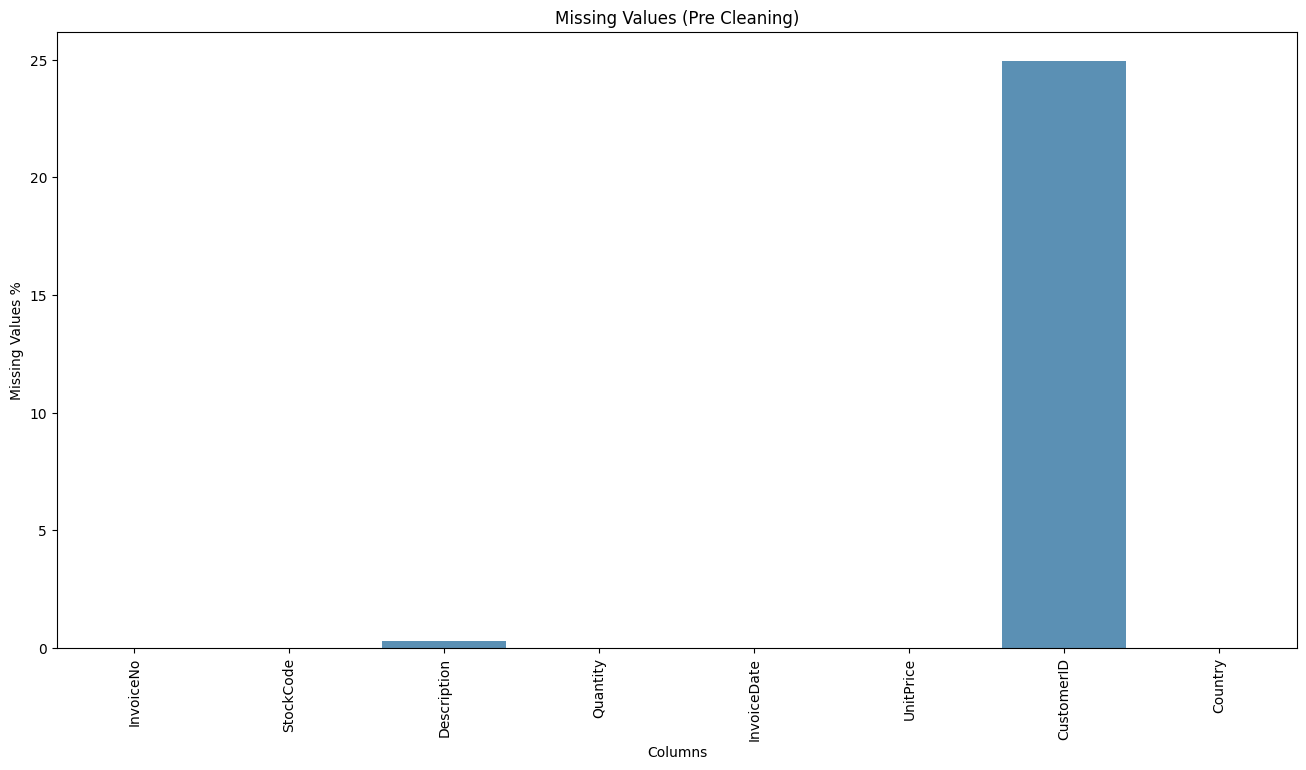

In [446]:
# Plotting the df_null

plt.figure(figsize=(16,8))
sns.barplot(x=df_null.index, y=df_null.values, alpha=0.8)
plt.title('Missing Values (Pre Cleaning)')
plt.ylabel('Missing Values %')
plt.xlabel('Columns')
plt.xticks(rotation=90)
plt.show()

In [447]:
# Droping rows having missing values
retail = retail.dropna()
retail.shape

(406829, 8)

`Explanation:` The missing values were scanned then it was removed.

In [448]:
# Calculating the Missing Values % contribution in DF
retail.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

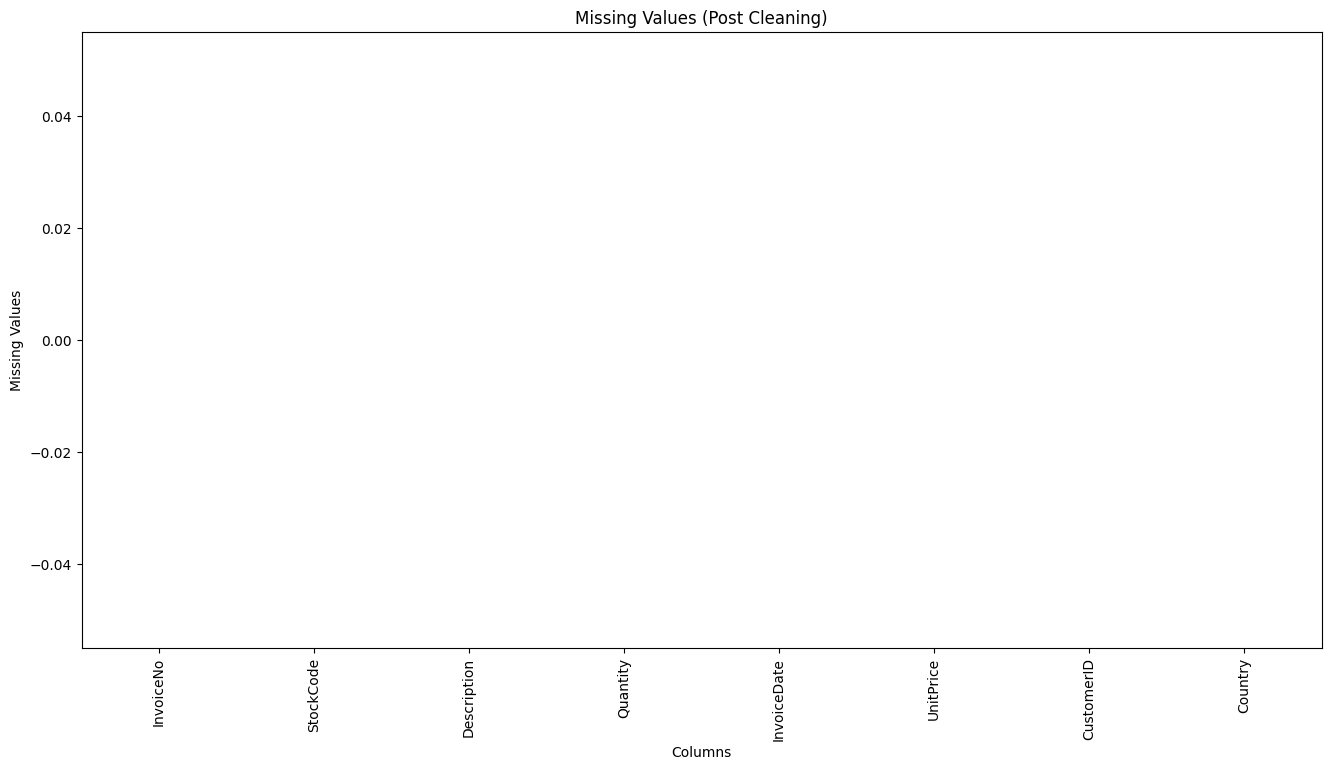

In [449]:
# Plotting a barplot for the retail to check if null values still exist

plt.figure(figsize=(16,8))
sns.barplot(x=retail.columns, y=retail.isna().sum().values, alpha=0.8)
plt.title('Missing Values (Post Cleaning)')
plt.ylabel('Missing Values')
plt.xlabel('Columns')
plt.xticks(rotation=90)
plt.show()

`Explanation:` The bar chart was represented by computing the percentage of missing values by column before and after preprocessing

Most of the missing values are in the ‘CustomerID’ column, and few are in the ‘Description’ column.

In [450]:
# Changing the datatype of Customer Id as per Business understanding
retail['CustomerID'] = retail['CustomerID'].astype(str)
retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


<a id="3"></a> <br>
### 3 : Data Preparation

#### Customers will be analyzed based on 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [451]:
# New Attribute : Monetary
retail['Amount'] = retail['Quantity'] * retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head(5)

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [452]:
# New Attribute : Frequency
rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head(5)



,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [453]:
# Merging the two dfs
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
print(rfm.shape)
rfm.head(5)

(4372, 3)


,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [454]:
# New Attribute : Recency
# Convert to datetime to proper datatype
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')



In [455]:
# Compute the maximum date to know the last transaction date
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [456]:
# Compute the difference between max date and transaction date
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [457]:
# Compute last transaction date to get the recency of customers
rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head(5)

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [458]:
# Extract number of days only
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head(5)


,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [459]:
# Merge tha dataframes to get the final RFM dataframe
rfm = pd.merge(rfm, rfm_p , on='CustomerID', how='inner')

In [460]:
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head(5)

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


## EDA

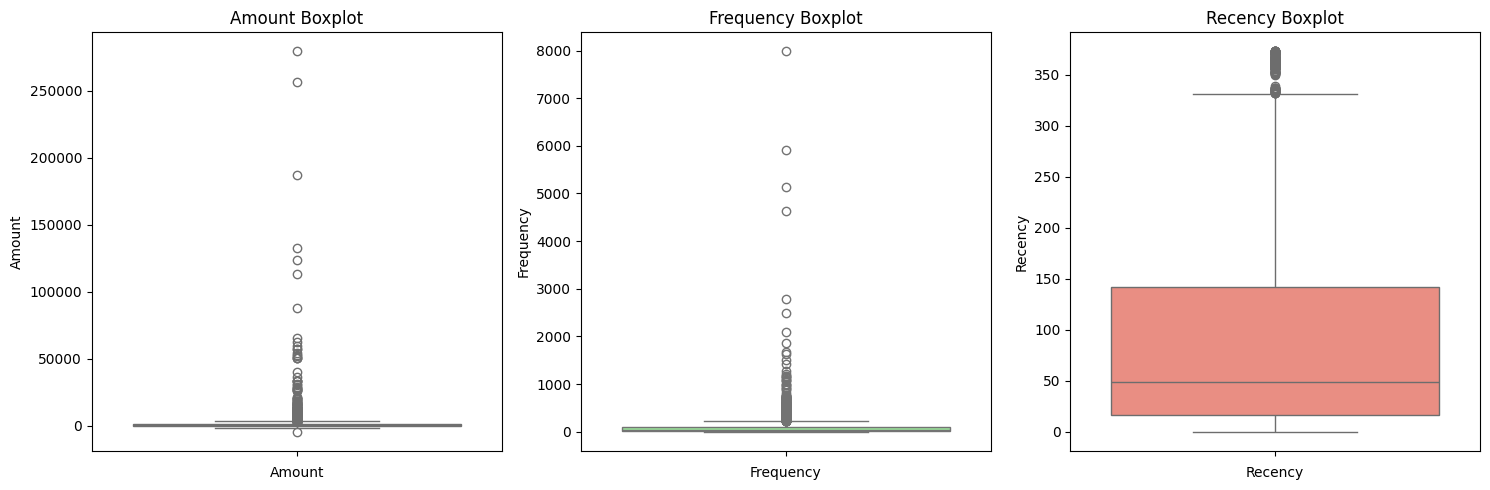

In [461]:
# Boxplot to identify outliers in the dataset

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=rfm['Amount'], color='skyblue')
plt.title('Amount Boxplot')
plt.xlabel('Amount')

plt.subplot(1, 3, 2)
sns.boxplot(data=rfm['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=rfm['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

`Explanation:` 

Boxplot on the other hand, helped us with summary statistics like easily identifying the median, quartile, and most especially, it is great for spotting outliers and understanding the data spread.

Similarly, like the histogram, it showed potential outliers distributed by identifying points that are isolated and far from the point clusters.


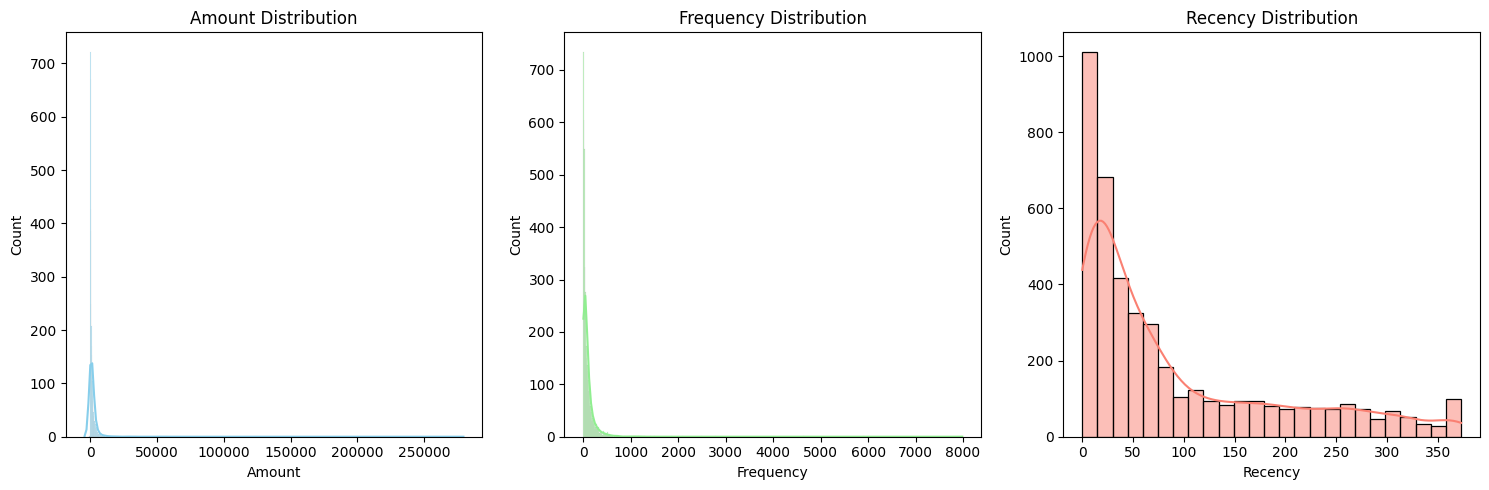

In [462]:
# Histogram for the distribution of at least two key numerical features

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm['Amount'], color='skyblue', kde=True)
plt.title('Amount Distribution')
plt.xlabel('Amount')

plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], color='lightgreen', kde=True)
plt.title('Frequency Distribution')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(rfm['Recency'], color='salmon', kde=True)
plt.title('Recency Distribution')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

`Explanation:`

Amount and Frequency both show a highly skewed distribution with numerous outliers, suggesting that a few customers make very large transactions or purchase very frequently, in contrast to the majority.

Recency is less skewed but still shows variability, with most customers being more recent in their activity, but some haven’t made purchases for a long time.

The histogram focuses on the distribution of a single variable, and we could understand the data through the skewness, normality, or multimodality.


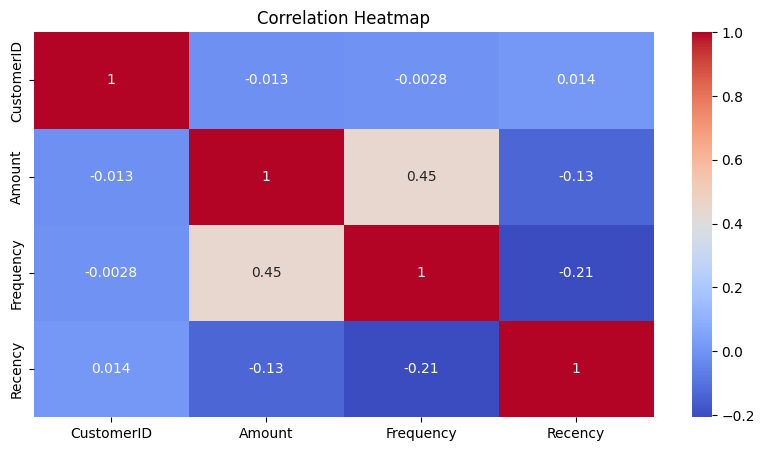

In [463]:
# Correlation heatmap to show relationships between numerical variables

plt.figure(figsize=(10,5))
sns.heatmap(rfm.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

`Explanation:`

The correlation heatmap helped us in which features or variables have a strong relationship or correlation with each other. When reviewing the correlation heatmap it gives

We found a positive correlation with the Amount and Frequency that we interpret as those customers who purchase more, spends more money.

Low correlation of CustomerID shows that it is trivial or it doesn’t correlate closely with features such as Amount, Frequency, and Recency.

#### Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.<br>
There are two common ways of rescaling:

1. Min-Max scaling 
2. Standardization (mean-0, sigma-1) 

Here we execute Standard Scaling.

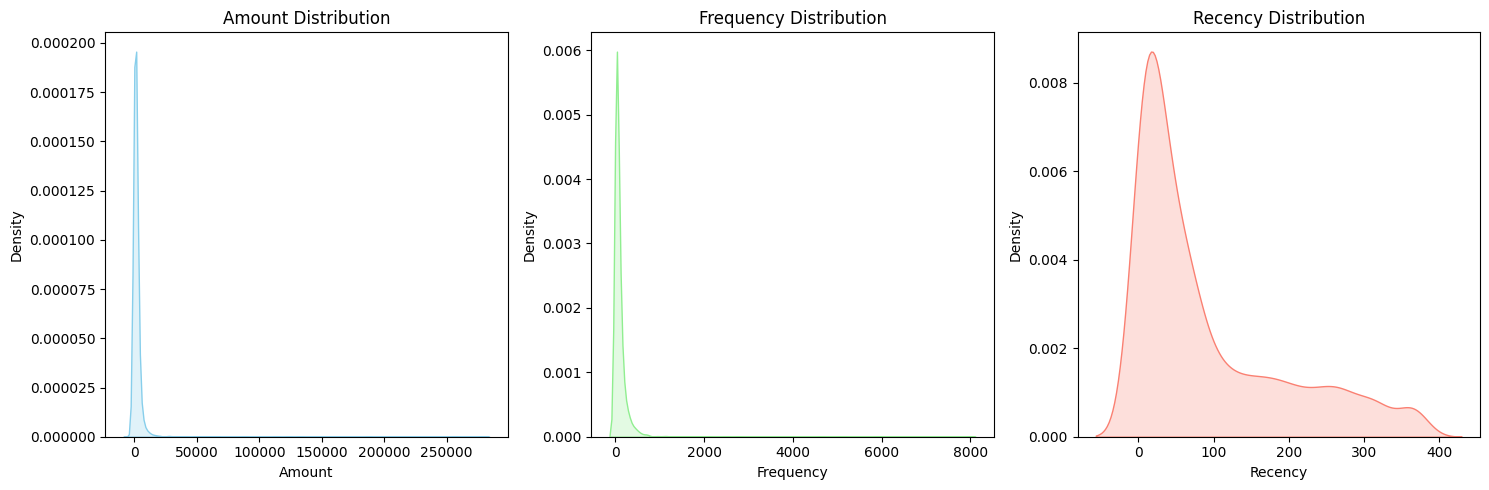

In [464]:
# Density Plot Before Scaling
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.kdeplot(rfm['Amount'], color='skyblue', fill=True)
plt.title('Amount Distribution')
plt.xlabel('Amount')

plt.subplot(1, 3, 2)
sns.kdeplot(rfm['Frequency'], color='lightgreen', fill=True)
plt.title('Frequency Distribution')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.kdeplot(rfm['Recency'], color='salmon', fill=True)
plt.title('Recency Distribution')

plt.tight_layout()
plt.show()

`Explanation:`

Before Scaling: The data for Amount, Frequency, and Recency are on vastly different scales.

 For example, Amount is spread across thousands, while Recency could span hundreds of days, and Frequency ranges from single digits to a few hundred.


In [465]:
# Rescaling the Attributes
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.shape

rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']

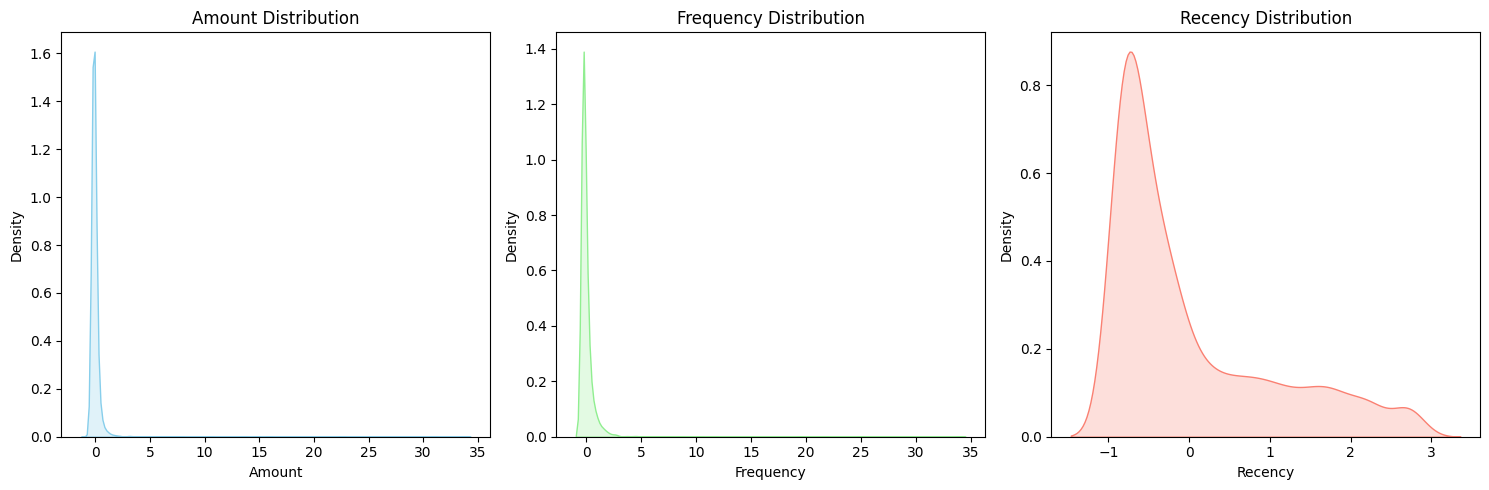

In [466]:
# Density Plot After Scaling
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.kdeplot(rfm_df_scaled['Amount'], color='skyblue', fill=True)
plt.title('Amount Distribution')
plt.xlabel('Amount')

plt.subplot(1, 3, 2)
sns.kdeplot(rfm_df_scaled['Frequency'], color='lightgreen', fill=True)
plt.title('Frequency Distribution')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.kdeplot(rfm_df_scaled['Recency'], color='salmon', fill=True)
plt.title('Recency Distribution')

plt.tight_layout()
plt.show()

`Explanation:`

After Standard Scaler: After applying the Standard Scaler (mean of 0, standard deviation of 1), all variables are transformed to a standard distribution. 

This ensures that they have comparable scales while maintaining the differences between high and low values.


## <span style="color: red;">Execute MinMax Scaling in the next box</span> 

In [467]:
from sklearn.preprocessing import MinMaxScaler

# Rescaling the Attributes
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate 
scaler = MinMaxScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.shape

rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']


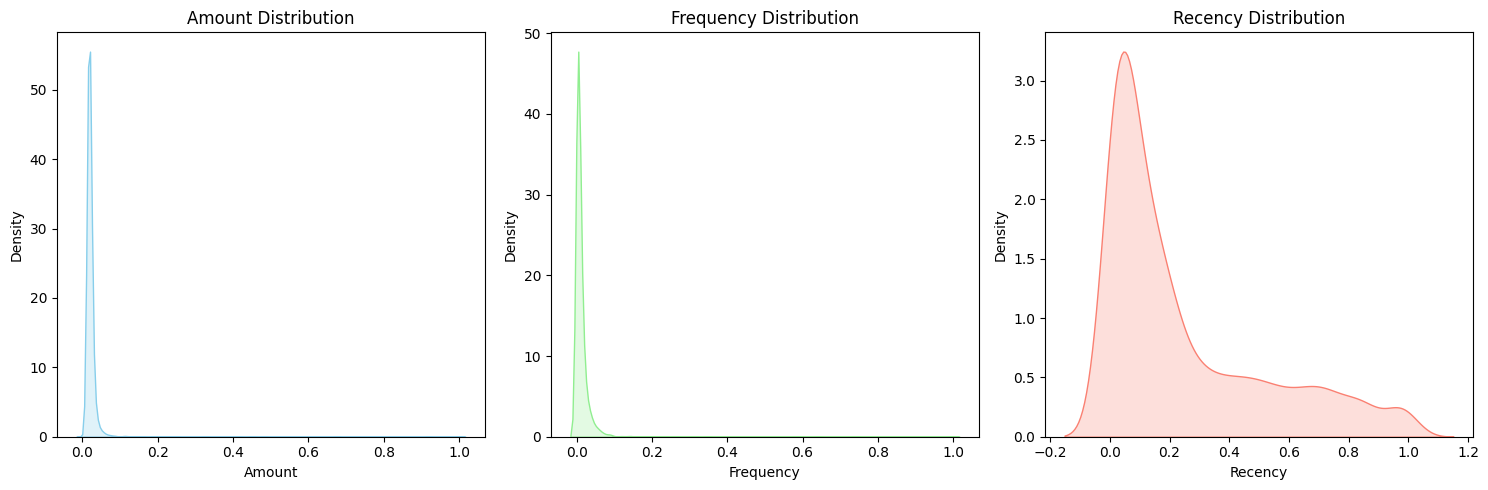

In [468]:
# Density Plot After Scaling
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.kdeplot(rfm_df_scaled['Amount'], color='skyblue', fill=True)
plt.title('Amount Distribution')
plt.xlabel('Amount')

plt.subplot(1, 3, 2)
sns.kdeplot(rfm_df_scaled['Frequency'], color='lightgreen', fill=True)
plt.title('Frequency Distribution')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.kdeplot(rfm_df_scaled['Recency'], color='salmon', fill=True)
plt.title('Recency Distribution')

plt.tight_layout()
plt.show()

`After MinMax Scaling`: MinMax scaling brings all the values into the range [0, 1], which is helpful for models sensitive to the magnitude of input values, especially clustering algorithms like K-means.


In [469]:
rfm_df_scaled.head(5)

,Amount,Frequency,Recency
0,0.015109,0.000125,0.871314
1,0.030297,0.022676,0.002681
2,0.021442,0.003758,0.198391
3,0.021303,0.009020,0.048257
4,0.016288,0.002005,0.828418


`Explain why this transformation is necessary for the next steps of the analysis: 
`

Clustering Algorithms (like K-means) are highly sensitive to the scale of the data. Variables on different scales can dominate the distance calculations, leading to biased clusters.

Standard Scaling helps preserve the original distribution but makes variables comparable, which is ideal for distance-based algorithms.

MinMax Scaling is crucial when the range of variables is important for algorithm stability, ensuring no variable dominates due to large ranges.


<a id="4"></a> <br>
### 4 : Building the Model

### K-Means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

In [470]:
# k-means with some arbitrary k
Kmeans = KMeans(n_clusters=4, max_iter=50)
Kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [471]:
Kmeans.labels_

array([0, 1, 3, ..., 1, 1, 1], dtype=int32)

In [472]:
# Create a K-means function here
def K_Means(X, n):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    model = KMeans(n)
    model.fit(X)
    cluster_labels = model.predict(X)
    cent = model.cluster_centers_
    return cluster_labels, cent

In [473]:
clust_labels, cent = K_Means(rfm_df, 3)
kmeans = pd.DataFrame(clust_labels)
rfm_df.insert((rfm_df.shape[1]), 'kmeans', kmeans)


In [474]:
rfm_df.head(5)

,Amount,Frequency,Recency,kmeans
0,0.00,2,325,1
1,4310.00,182,1,0
2,1797.24,31,74,0
3,1757.55,73,18,0
4,334.40,17,309,1


In [475]:
# Plot your clusters
def Plot3dClustering(n, X, type_c):
    data = []
    clusters = []
    colors = ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)']
    
    for i in range(n):
        name = i
        color = colors[i]
        x = X[X[type_c] == i]['Amount']
        y = X[X[type_c] == i]['Frequency']
        z = X[X[type_c] == i]['Recency']
        
        trace = dict(
            name = name,
            x = x, y = y, z = z,
            type = 'scatter3d',
            mode = 'markers',
            marker = dict(size = 3, color = color, line = dict(width = 0)))
        data.append(trace)
        
        cluster = dict(
            color = color,
            opacity = 0.1,
            type = 'mesh3d',
            alphahull = 7,
            name = "y",
            x = x, y = y, z = z)
        data.append(cluster)
        
    layout = dict(
        width = 800,
        height = 550,
        autosize = False,
        title = '3D Clustering Plot',
        scene = dict(
            xaxis = dict(
                gridcolor = 'rgb(255, 255, 255)',
                zerolinecolor = 'rgb(255, 255, 255)',
                showbackground = True,
                title='Amount',
                backgroundcolor = 'rgb(230, 230, 230)',
                ),
            yaxis = dict(
                gridcolor = 'rgb(255, 255, 255)',
                zerolinecolor = 'rgb(255, 255, 255)',
                showbackground = True,
                title='Frequency',
                backgroundcolor = 'rgb(230, 230, 230)',
                ),
            zaxis = dict(
                gridcolor = 'rgb(255, 255, 255)',
                zerolinecolor = 'rgb(255, 255, 255)',
                showbackground = True,
                title='Recency',
                backgroundcolor = 'rgb(230, 230, 230)',
                ),
            aspectratio = dict(x=1, y=1, z=0.7),
            aspectmode = 'manual'
        ),
    )
        
    fig = dict(data = data, layout = layout)
    iplot(fig, filename='3d-scatter-colorscale', validate=False)
    

In [476]:
Plot3dClustering(n=3, X=rfm_df, type_c='kmeans')

`Describe the characteristics of the 3D Scatter Plot
`

The data points are mainly differentiated by Recency, with clear divisions between recent, moderately recent, and older transactions.

Amount and Frequency also contribute to cluster differentiation, especially for older, high-amount transactions (green) versus more recent, low-amount transactions (blue and red).


`Describe the characteristics of each cluster and the clustering results based on the visualization.
`

Red Cluster (central, vertical stretch): Represents transactions or events with varying Recency but generally low Frequency. The Amount stays moderate, ranging from 0 to 100k. These could be regular but infrequent transactions happening over a wide range of time periods.

Green Cluster (spread at the base): Represents older transactions (low Recency), with a broad range in Frequency and Amount. Some transactions in this group have high amounts (up to 250k), suggesting less frequent but larger, older transactions.

Blue Cluster (top, stacked): Represents recent transactions with low Frequency and smaller Amount values (up to 50k). These are more recent events but occur less frequently and involve smaller monetary amounts.


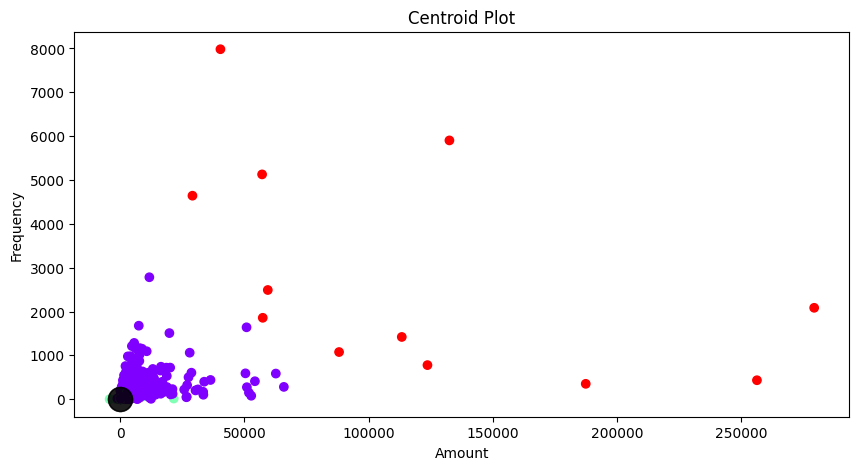

In [477]:
# Cluster Centroid Plot

plt.figure(figsize=(10, 5))
plt.title('Centroid Plot')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.scatter(rfm_df['Amount'], rfm_df['Frequency'], c=rfm_df['kmeans'], cmap='rainbow')
plt.scatter(cent[:,0], cent[:,1], c='black', s=300, alpha=0.5)
plt.show()

## <span style="color: red;">Finding the Optimal Number of Clusters</span> 

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

Text(0.5, 1.0, 'Elbow Method')

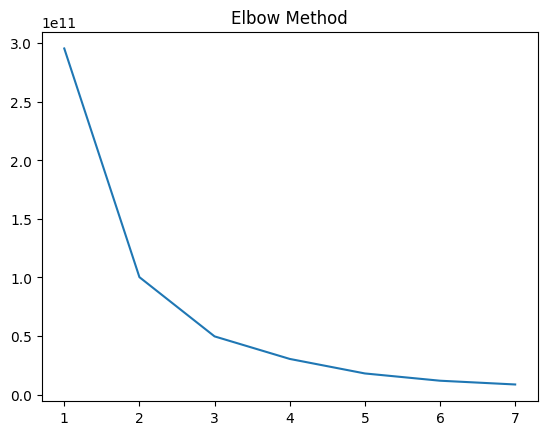

In [478]:
X = rfm_df
wcss = []
for i in range(1,8):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=7, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,8), wcss)
plt.title('Elbow Method')

Silhouette Score for 3 clusters: 0.7259254699742556


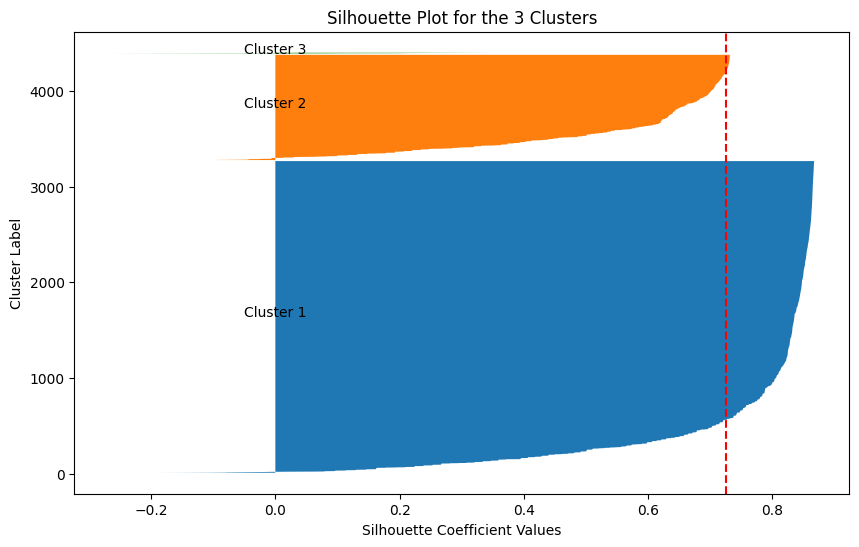

In [479]:
from sklearn.metrics import silhouette_score

# Visualize silhouette score for each cluster using a Silhouette plot
silhouette_avg = silhouette_score(rfm_df_scaled, rfm_df['kmeans'])
print(f'Silhouette Score for 3 clusters: {silhouette_avg}')

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples

# Calculate silhouette values
sample_silhouette_values = silhouette_samples(rfm_df_scaled, rfm_df['kmeans'])

# Create a silhouette plot
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(3):  # Change to 3 for 3 clusters
    # Aggregate the silhouette scores for samples belonging to the current cluster
    ith_cluster_silhouette_values = sample_silhouette_values[rfm_df['kmeans'] == i]
    ith_cluster_silhouette_values.sort()
    
    # Get the size of the cluster
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    
    # Compute the y position for the current cluster
    y_upper = y_lower + size_cluster_i
    
    # Fill the silhouette plot for the current cluster
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values)
    
    # Label the silhouette plots
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i + 1}')
    
    # Update the next y_lower position
    y_lower = y_upper + 10  # 10 for the 10px separation between clusters

plt.title('Silhouette Plot for the 3 Clusters')
plt.xlabel('Silhouette Coefficient Values')
plt.ylabel('Cluster Label')
plt.axvline(x=silhouette_avg, color='red', linestyle='--')
plt.show()

`Explanation:`The silhouette plot helps determine whether clusters are well-defined and can reveal points that may be misclassified or potential outliers. By examining the silhouette coefficient values, we can assess how well each point fits into its assigned cluster. Points with high values (close to 1) are well-clustered, while negative or near-zero values suggest poor clustering, misclassification, or the presence of outliers.

The plot revealed that:

Overall, the silhouette score across all clusters is relatively high, signifying that the clustering is good overall and points are well-placed.

However, a few points show low or negative silhouette values, particularly in Cluster 1, which may indicate potential outliers or points that are not well separated from other clusters. These points might benefit from further investigation or reassignment to other clusters, as they do not fit as neatly into the current grouping.

In summary, the clustering is robust, but there are some instances of borderline points or possible outliers that may require attention to refine the model further.


## <span style="color: red;">Box Plots of Clusters created</span> 

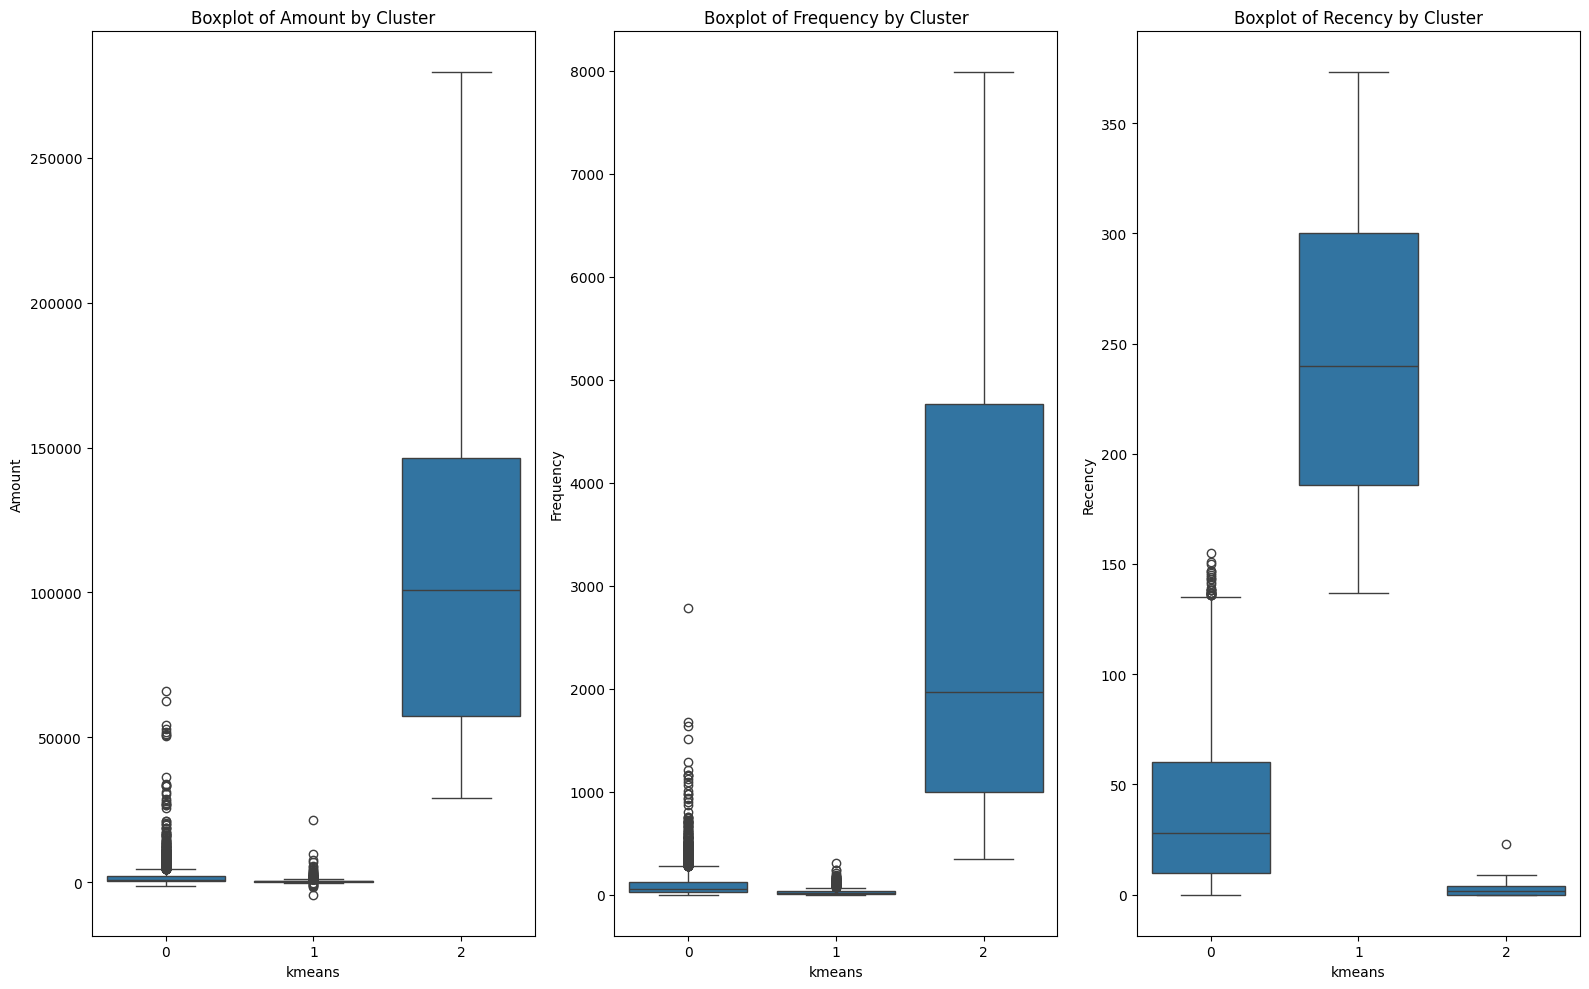

In [480]:
# Creating the plot
plt.figure(figsize=(16, 10))

# Create a subplot for each feature
for i, feature in enumerate(['Amount', 'Frequency', 'Recency'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='kmeans', y=feature, data=rfm_df)
    plt.title(f'Boxplot of {feature} by Cluster')

# Show the plot
plt.tight_layout()
plt.show()


`Analysis:`

- The box plot reveals a significant disparity in the spending behavior across the clusters.

- Overall, the box plots highlight the distinct characteristics of each cluster in terms of spending habits, purchase frequency, and recency of transactions. Cluster 0 represents low spenders who shop infrequently but recently, while Cluster 1 consists of moderate spenders with a balanced shopping frequency. Cluster 2, on the other hand, captures high spenders who shop frequently but may have become less recent, indicating an opportunity for targeted marketing strategies to rekindle their engagement. This differentiation in customer behavior is essential for tailoring marketing efforts and improving customer relationship management strategies. ​


<a id="5"></a> <br>
## Step 5 : Final Analysis

## <span style="color: red;">Findings</span> 

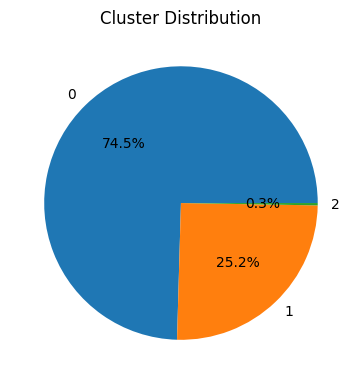

In [481]:
# Show the distribution of data points across the clusters using pie chart

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
rfm_df['kmeans'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Cluster Distribution')
plt.ylabel('')
plt.show()

`Explanation:`

The pie chart shows the distribution of three customer clusters, with Cluster 0 accounting for 74.5%, Cluster 1 for 25.2%, and Cluster 2 for only 0.3%. These clusters are visually represented in the scatter plot, where Cluster 0 (blue) consists of customers who make frequent and recent purchases with high spending, dominating the plot. Cluster 1 (orange/red) includes occasional buyers with moderate frequency and recency, while Cluster 2 (green) represents a small group of inactive customers with low engagement, corresponding to its minimal share in the pie chart. The scatter plot thus reinforces the cluster sizes shown in the pie chart by depicting their purchasing behavior.

#### Student Name: 4CSC
- Benjamin Francis Abadila
- Angelo Dela Paz
- Carl Mitzchel Padua
- Edjin Jerney Payumo
- Levin Jacob Sta. Cruz